In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import pyscisci.all as pyscisci

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
try:
    import seaborn as sns
    sns.set_style('white')
except:
    pass

%matplotlib inline

In [3]:
# set this path to where the APS database is stored
path2aps = '/home/ajgates/APS'


In [4]:
myaps = pyscisci.APS(path2aps, database_extension='csv.gz', keep_in_memory=False) 

# set keep_in_memory=False if you want to load the database each time its needed - good for when you 
# cant keep more than one DataFrame in memory at a time

# otherwise keep_in_memory=True will keep each DataFrame in memory after its loaded

In [5]:
pub2ref  = myaps.pub2ref 
pubdf = myaps.pub[['PublicationId', 'Date', 'Year']]
pubdf['Date'] = pd.to_datetime(pubdf['Date'], infer_datetime_format=True)

Loading pub2ref:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Publications:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
print(pub2ref.shape)

pub2ref = pub2ref.merge(pubdf[['PublicationId', 'Date', 'Year']], 
                                            how='left', left_on='CitingPublicationId', right_on='PublicationId')
del pub2ref ['PublicationId']
pub2ref  = pub2ref.rename(columns={'Date':'CitingDate', 'Year':'CitingYear'})

pub2ref  = pub2ref.merge(pubdf[['PublicationId', 'Date', 'Year']], 
                                            how='left', left_on='CitedPublicationId', right_on='PublicationId')
del pub2ref ['PublicationId']
pub2ref  = pub2ref .rename(columns={'Date':'CitedDate', 'Year':'CitedYear'})

pub2ref.dropna(inplace=True)

print(pub2ref.shape)

(8324631, 2)
(8267865, 6)


In [7]:
pub2ref.groupby('CitedPublicationId')['CitingPublicationId'].nunique().sort_values()

CitedPublicationId
10.1103/PhysRev.1.1                1
10.1103/PhysRevA.39.2411           1
10.1103/PhysRevD.55.6403           1
10.1103/PhysRevD.55.6584           1
10.1103/PhysRevD.55.6603           1
                               ...  
10.1103/PhysRevB.50.17953       5464
10.1103/PhysRev.136.B864        6218
10.1103/PhysRevB.54.11169       7444
10.1103/PhysRev.140.A1133       7734
10.1103/PhysRevLett.77.3865    10666
Name: CitingPublicationId, Length: 561040, dtype: int64

In [8]:
focusids = np.sort(['10.1103/PhysRev.136.B864', '10.1103/PhysRevLett.77.3865', '10.1103/PhysRev.140.A1133'])
focus_cites = pub2ref.loc[pyscisci.isin_sorted(pub2ref ['CitedPublicationId'].values, focusids)]
focus_cites.sort_values(by=['CitingDate'], inplace=True)
focus_cites.shape

/var/folders/69/w28tw6xx26nd7x4yv_sh2mgm0000gp/T/ipykernel_53024/337035123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_cites.sort_values(by=['CitingDate'], inplace=True)


(24618, 6)

# Longterm Citation

In [8]:
longtermimpact = pyscisci.longterm_impact(focus_cites, colgroupby = 'CitedPublicationId', coldate='CitingDate')
longtermimpact

,CitedPublicationId,lam,mu,sig
0,10.1103/PhysRev.136.B864,6.205512,9.044825,0.788842
1,10.1103/PhysRev.140.A1133,6.678506,8.936498,0.977601
2,10.1103/PhysRevLett.77.3865,8.120082,8.191955,1.419675


/var/folders/69/w28tw6xx26nd7x4yv_sh2mgm0000gp/T/ipykernel_4769/3681678537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_cites.sort_values(by=['CitingDate'], inplace=True)


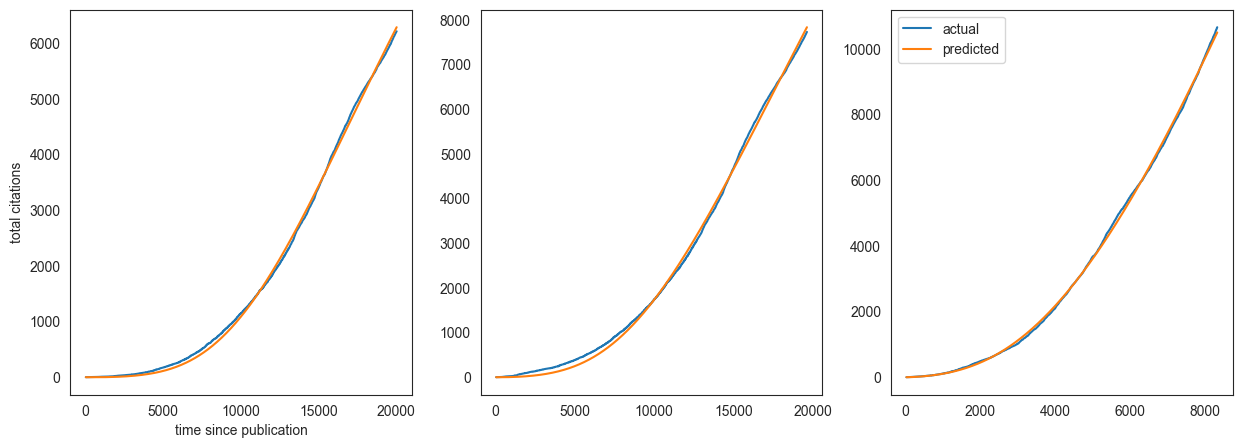

In [9]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

focus_cites.sort_values(by=['CitingDate'], inplace=True)

for iax in range(len(focusids)):
    focus  = focus_cites[focus_cites['CitedPublicationId']==focusids[iax]]
    recenter_time = (focus ['CitingDate'] - focus ['CitingDate'].min() ) / np.timedelta64(1,'D')
    recenter_time = recenter_time[recenter_time>0]
    
    lam, mu, sig = longtermimpact[longtermimpact['CitedPublicationId'] == focusids[iax]][['lam', 'mu', 'sig']].values[0]
    ax[iax].plot(recenter_time, np.arange(1,len(recenter_time) + 1), label='actual') 
    
    ax[iax].plot(recenter_time, [pyscisci.predicted_c(t, lam, mu, sig) 
                                 for t in recenter_time], label='predicted')
    
ax[0].set_ylabel('total citations')
ax[0].set_xlabel('time since publication')
    
plt.legend()
plt.show()

# Disruption Index

In [10]:
disrupt = pyscisci.disruption_index(pub2ref, focus_pub_ids = focusids)
disrupt

,PublicationId,DisruptionIndex
0,10.1103/PhysRev.136.B864,0.780082
1,10.1103/PhysRev.140.A1133,-0.358467
2,10.1103/PhysRevLett.77.3865,0.252897


# Sleeping Beauty Coefficient

In [9]:
annual_cites = pub2ref.groupby(['CitedPublicationId', 'CitingYear'])['CitingPublicationId'].nunique()
annual_cites = annual_cites.to_frame().reset_index().rename(columns={'CitingPublicationId':'Citations'})

annual_cites = annual_cites[pyscisci.isin_sorted(annual_cites['CitedPublicationId'].values, focusids)]
annual_cites

,CitedPublicationId,CitingYear,Citations
112224,10.1103/PhysRev.136.B864,1965.0,3
112225,10.1103/PhysRev.136.B864,1966.0,1
112226,10.1103/PhysRev.136.B864,1967.0,5
112227,10.1103/PhysRev.136.B864,1968.0,3
112228,10.1103/PhysRev.136.B864,1969.0,4
...,...,...,...
3080030,10.1103/PhysRevLett.77.3865,2015.0,728
3080031,10.1103/PhysRevLett.77.3865,2016.0,818
3080032,10.1103/PhysRevLett.77.3865,2017.0,854
3080033,10.1103/PhysRevLett.77.3865,2018.0,956


In [18]:
beauty = pyscisci.compute_sleepingbeauty(annual_cites, colgroupby='CitedPublicationId', colcountby='Citations',
                                        coldate='CitingYear')
beauty

,CitedPublicationId,BeautyCoefficient,Awakening
0,10.1103/PhysRev.136.B864,55.165570,1996.0
1,10.1103/PhysRev.140.A1133,21.272430,1997.0
2,10.1103/PhysRevLett.77.3865,4.664782,2014.0


# Network-normalized citation

In [27]:
focusids = np.sort(['10.1103/PhysRev.136.B864', '10.1103/PhysRevLett.77.3865', '10.1103/PhysRev.140.A1133'])

netnorm = pyscisci.netnormcite_index(pub2ref, T=5, focus_pub_ids = focusids)
netnorm

,PublicationId,CitedYear,Cnorm5
0,10.1103/PhysRev.136.B864,1964.0,3.757856
1,10.1103/PhysRev.140.A1133,1965.0,18.087836
2,10.1103/PhysRevLett.77.3865,1996.0,59.054782
